# 3 TESTING NOTEBOOK

## Install packages

In [ ]:
# INSTALL SCIKERAS PACKAGES
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import libraries

In [ ]:
# IMPORT TENSORFLOW/KERAS
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
# from keras.preprocessing import image
from tensorflow.keras.preprocessing import image
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions

from keras.layers.core import Flatten
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

# SCIKIT-LEARN/SCIKERAS
from sklearn import preprocessing
import sklearn.metrics as metrics
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report

# IMPORT OTHER MODULES
import os
import sys
import glob
import datetime
from pathlib import Path

import fnmatch # to count number of image per folder easily
import random # to select random images from a folder
import numpy as np
import pandas as pd
from os import mkdir
import seaborn as sns
from pathlib import Path
from shutil import copyfile # to import "copyfile"
from numpy.random import seed
import matplotlib.image as img_mat
import plotly.figure_factory as ff # for printing the heatmap
from collections import defaultdict
from matplotlib import pyplot as plt
from IPython.display import Javascript

# CV2
import cv2
from google.colab.patches import cv2_imshow 

ModuleNotFoundError: ignored

In [ ]:
# SET RANDOM SEED TO GET, AS MUCH AS POSSIBLE, REPRODUCIBLE RESULTS
# USING NUMPY
seed(42)

# USING TENSORFLOW: IN ADDITION, TENSORFLOW HAS ITS OWN RANDOM NUMBER
# GENERATOR THAT MUST ALSO BE SEEDED BY CALLING THE SET_RANDOM_SEED()
# FUNCTION IMMEDIATELY AFTER THE NUMPY RANDOM NUMBER GENERATOR
tf.random.set_seed(42)

In [ ]:
# Link Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# IMPORT UTILS.PY

# 1.Insert the directory
sys.path.insert(0,"/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food")

# 2.Import your module or file
import utils

In [ ]:
# CONSTANT
# SCALE_PERCENT = 6 # resizing percentage
SEED_VALUE = 42
num_classes = 10 # number of output classes
batch_size = 16
SIZE = 96  #Resize images --> https://www.researchgate.net/post/Which_Image_resolution_should_I_use_for_training_for_deep_neural_network#:~:text=So%20the%20rule%20of%20thumb,for%20something%20smaller%20and%20easier.
xx = ['caesar_salad', 'caprese_salad', 'french_fries', 'greek_salad', 'hamburger', 'hot_dog', 'pizza', 'sashimi', 'sushi', 'rejection_class']
yy = ['caesar_salad', 'caprese_salad', 'french_fries', 'greek_salad', 'hamburger', 'hot_dog', 'pizza', 'sashimi', 'sushi', 'rejection_class']


# PATH TO THE DATA
ORIGINAL_DATA = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset"
PREPROCESSED_DATA = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDatasetPreprocessed"
DIR_TRAIN_TEST_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test' # path contenente i sottoinsiemi di train, test

# LOAD THE FOLDERS WHERE THE TRAINING/TESTING/VALIDATION DATA ARE STORED
base_path_train = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/'
base_path_test = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/'
base_path_val = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/val/'

# PATH TO THE DATA
DIR_TRAIN_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/*' # path contenente i sottoinsiemi di train, test
DIR_TEST_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/*' # path contenente i sottoinsiemi di train, test
DIR_VAL_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/val/*' # path contenente i sottoinsiemi di train, test

In [ ]:
# SETTINGS FOR PRETTIER VISUALIZATION IN GOOGLE COLAB
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

In [ ]:
def fn_load_image(img_path, show=True):

    img = image.load_img(img_path, target_size=(SIZE, SIZE))
    # img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                   # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    # img_tensor = preprocess_input(img_tensor)
    # img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

<IPython.core.display.Javascript object>

In [ ]:
# Capture training data and labels into respective lists
train_images = []
train_labels = [] 

# GET THE LABELS
for directory_path in glob.glob(DIR_TRAIN_DATA):
    tr_label = directory_path.split("/")[-1]
    print(tr_label)
    # GET THE IMAGES
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        # print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(tr_label)

# CONVERT LISTS TO ARRAYS
train_images = np.array(train_images)
train_labels = np.array(train_labels)

################################################################
# CAPTURE TEST/VALIDATION DATA AND LABELS INTO RESPECTIVE LISTS

test_images = []
test_labels = [] 
for directory_path in glob.glob(DIR_TEST_DATA):
    tt_label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(tt_label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

<IPython.core.display.Javascript object>

french_fries
caprese_salad
pizza
greek_salad
sashimi
hot_dog
caesar_salad
hamburger
sushi
rejection_class


# 1.Evaluate and Test on the test data

## 1.1 Load the best Model

In [ ]:
# LOAD SAVED MODEL AND GET PATH FOR AN IMAGE
best_model = tf.keras.models.load_model("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/model_mobilenetV2_96x96.h5") 

<IPython.core.display.Javascript object>

In [ ]:
def prepare_image(file):
    # img_path = 'data/MobileNet-samples/'
    img = image.load_img(file, target_size=(96, 96))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

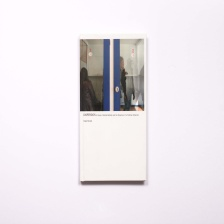

In [ ]:
from IPython.display import Image
Image(filename='/content/04_Dispersion_by_Husos.jpg_RESIZED.jpg') 

In [ ]:
preprocessed_image = prepare_image('/content/04_Dispersion_by_Husos.jpg_RESIZED.jpg')
predictions = best_model.predict(preprocessed_image)

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 34ms/step


In [ ]:
predictions

<IPython.core.display.Javascript object>

array([[0.05104251, 0.01715058, 0.08446782, 0.00254825, 0.47321278,
        0.0661402 , 0.03873768, 0.12435503, 0.0911835 , 0.05116162]],
      dtype=float32)

In [ ]:
# test_datagen_mnetv2 = ImageDataGenerator(rescale=1./255) 
test_datagen_mnetv2 = ImageDataGenerator(rescale=1./255) 

# TOGLIERE: USARE SOLO NEL NOTEBOOK DI TEST!
test_generator = test_datagen_mnetv2.flow_from_directory(
    base_path_test,
    target_size=(SIZE, SIZE), # target_size=(224,224),
    # target_size=(224,224),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
    seed = SEED_VALUE)

<IPython.core.display.Javascript object>

Found 132 images belonging to 10 classes.


In [ ]:
# test_generator.reset()

<IPython.core.display.Javascript object>

**MODIFICARE QUESTA PARTE!!!**

In [ ]:
# # img_path_caesar = "/content/crop_caesar8.jpg"
# img_path_hamb = "/content/hamburger_496.jpg"
# # img_path_fries = "/content/20160725_123734.jpg"

# # img = image.load_img(img_path, target_size=(224, 224))
# img = fn_load_image(img_path_hamb)
# # x = image.img_to_array(img)
# # x = np.expand_dims(img, axis=0)
# # x = preprocess_input(x)
# preds= best_model.predict(img)
# print(preds)
# # create a list containing the class labels
# class_labels = ['caesar_salad', 'caprese_salad', 'french_fries', 'greek_salad', 'hamburger', 'hot_dog', 'pizza', 'sashimi', 'sushi', 'rejection_class']
# # find the index of the class with maximum score
# pred = np.argmax(preds, axis=-1)
# print(pred)
# # print the label of the class with maximum score
# print(class_labels[pred[0]])

In [ ]:
# # PREDICT USING THE BEST MODEL
# # Y_pred = model_mobilenetv2.predict(val_generator, val_generator.n // val_generator.batch_size)
# Y_pred = best_model.predict(test_generator, test_generator.n // test_generator.batch_size)

# test_preds = np.argmax(Y_pred, axis=1)
# test_trues = test_generator.classes
# print(test_trues)

# # PRINT THE CLASSIFICATION REPORT
# print(classification_report(test_trues, test_preds))

**Confusion Matrix**

A confusion matrix is a table that is often used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known.

**Create a heatmap as a confusion matrix**

In [ ]:
# #  VISUALIZATION OF THE CONFUSION MATRIX
# plt.figure(figsize=(20,12))

# # Y_pred = model_mobilenetv2.predict(val_generator, val_generator.n // val_generator.batch_size)
# Y_pred = best_model.predict(test_generator, test_generator.n // test_generator.batch_size)

# test_preds = np.argmax(Y_pred, axis=1)
# test_trues = test_generator.classes

# # PRINT THE CONFUSION MATRIX
# cm = metrics.confusion_matrix(test_trues, test_preds)
# heatmap = sns.heatmap(cm, annot=True)
# heatmap.set_title('Confusion matrix')
# heatmap.set_xticks(range(len(xx))) # <--- set the ticks first
# heatmap.set_xticklabels(xx) # <--- then labels

# heatmap.set_yticks(range(len(yy)))
# heatmap.set_yticklabels(labels = (yy), rotation=45)

In [ ]:
# CREATE A LIST TO STORE THE PATH OF EACH RANDOM IMAGE
inference_data = list()

current_directory = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/")

for folder in current_directory.iterdir():
  split_str = str(folder).split("/")[-1] # get the folder name
  file_path_type = [f"/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/{split_str}/*.jpg"]  
  images = glob.glob(random.choice(file_path_type))
  print(images)

  for i in range(2):
    random_image = random.choice(images)
    print(random_image)
    inference_data.append(random_image)
    # img_raw = cv2.imread(random_image)

<IPython.core.display.Javascript object>

['/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/french_fries/cropfries31.jpg_RESIZED.jpg', '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/french_fries/cropfries14.jpg_RESIZED.jpg', '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/french_fries/cropfries33.jpg_RESIZED.jpg', '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/french_fries/cropfries61.jpg_RESIZED.jpg', '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/french_fries/cropfries28.jpg_RESIZED.jpg', '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/french_fries/cro

**Load multiple images and predict**

In [ ]:
# from sklearn.metrics import plot_confusion_matrix
# Y_pred = best_model.predict(test_generator)
# y_pred = np.argmax(Y_pred, axis=1)

# import sklearn.metrics as metrics
# test_trues = test_generator.classes

# from sklearn.metrics import classification_report
# print(classification_report(test_trues, y_pred))

In [ ]:
# Y_pred = best_model.predict(test_generator, test_generator.samples / batch_size)
# test_preds = np.argmax(Y_pred, axis=1)

# import sklearn.metrics as metrics
# test_trues = test_generator.classes

# from sklearn.metrics import classification_report
# print(classification_report(test_trues, test_preds))

<IPython.core.display.Javascript object>

french_fries


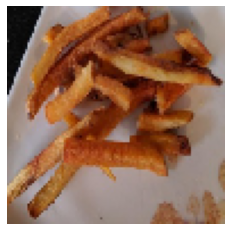

1/1 [==============================] - 0s 97ms/step
Output index is: [5]

The food predicted is: hot_dog.
------------------------ NEXT IMAGE ----------------------------

french_fries


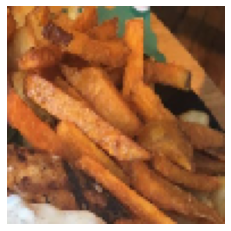

1/1 [==============================] - 0s 78ms/step
Output index is: [5]

The food predicted is: hot_dog.
------------------------ NEXT IMAGE ----------------------------

caprese_salad


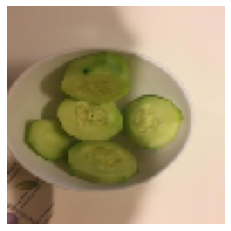

1/1 [==============================] - 0s 57ms/step
Output index is: [0]

The food predicted is: caesar_salad.
------------------------ NEXT IMAGE ----------------------------

caprese_salad


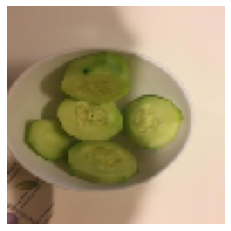

1/1 [==============================] - 0s 56ms/step
Output index is: [0]

The food predicted is: caesar_salad.
------------------------ NEXT IMAGE ----------------------------

pizza


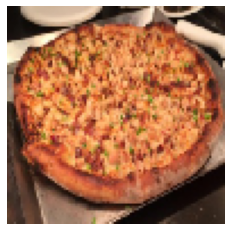

1/1 [==============================] - 0s 65ms/step
Output index is: [4]

The food predicted is: hamburger.
------------------------ NEXT IMAGE ----------------------------

pizza


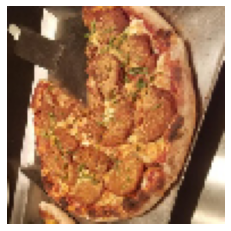

1/1 [==============================] - 0s 77ms/step
Output index is: [4]

The food predicted is: hamburger.
------------------------ NEXT IMAGE ----------------------------

greek_salad


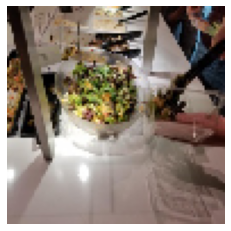

1/1 [==============================] - 0s 56ms/step
Output index is: [5]

The food predicted is: hot_dog.
------------------------ NEXT IMAGE ----------------------------

greek_salad


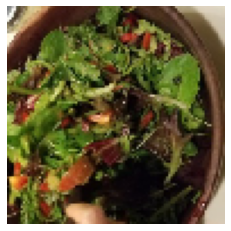

1/1 [==============================] - 0s 65ms/step
Output index is: [8]

The food predicted is: sashimi.
------------------------ NEXT IMAGE ----------------------------

sashimi


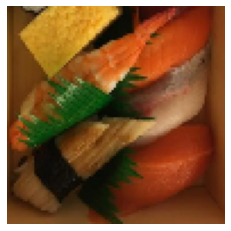

1/1 [==============================] - 0s 75ms/step
Output index is: [5]

The food predicted is: hot_dog.
------------------------ NEXT IMAGE ----------------------------

sashimi


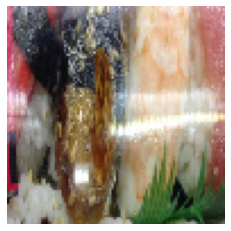

1/1 [==============================] - 0s 56ms/step
Output index is: [8]

The food predicted is: sashimi.
------------------------ NEXT IMAGE ----------------------------

hot_dog


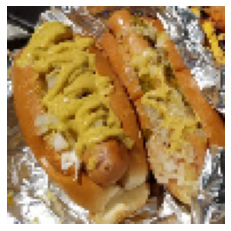

1/1 [==============================] - 0s 61ms/step
Output index is: [5]

The food predicted is: hot_dog.
------------------------ NEXT IMAGE ----------------------------

hot_dog


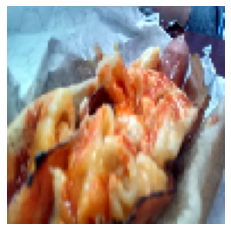

1/1 [==============================] - 0s 37ms/step
Output index is: [5]

The food predicted is: hot_dog.
------------------------ NEXT IMAGE ----------------------------

caesar_salad


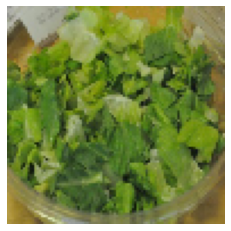

1/1 [==============================] - 0s 33ms/step
Output index is: [5]

The food predicted is: hot_dog.
------------------------ NEXT IMAGE ----------------------------

caesar_salad


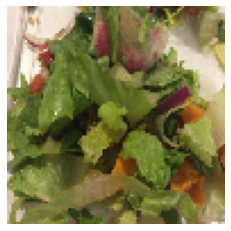

1/1 [==============================] - 0s 37ms/step
Output index is: [5]

The food predicted is: hot_dog.
------------------------ NEXT IMAGE ----------------------------

hamburger


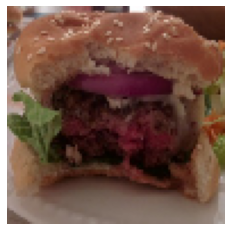

1/1 [==============================] - 0s 33ms/step
Output index is: [5]

The food predicted is: hot_dog.
------------------------ NEXT IMAGE ----------------------------

hamburger


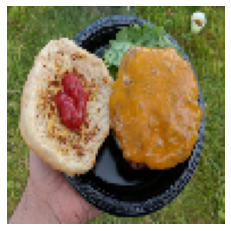

1/1 [==============================] - 0s 37ms/step
Output index is: [5]

The food predicted is: hot_dog.
------------------------ NEXT IMAGE ----------------------------

sushi


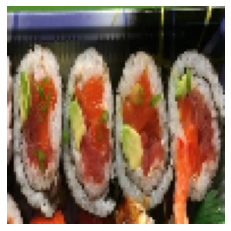

1/1 [==============================] - 0s 32ms/step
Output index is: [5]

The food predicted is: hot_dog.
------------------------ NEXT IMAGE ----------------------------

sushi


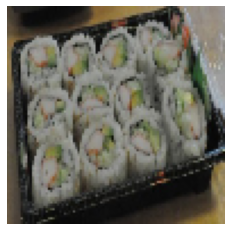

1/1 [==============================] - 0s 34ms/step
Output index is: [1]

The food predicted is: caprese_salad.
------------------------ NEXT IMAGE ----------------------------

rejection_class


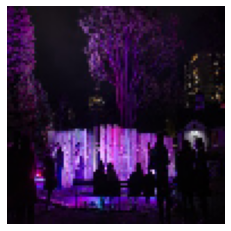

1/1 [==============================] - 0s 37ms/step
Output index is: [5]

The food predicted is: hot_dog.
------------------------ NEXT IMAGE ----------------------------

rejection_class


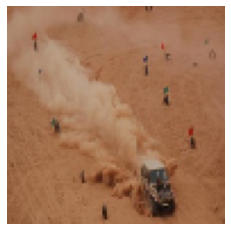

1/1 [==============================] - 0s 40ms/step
Output index is: [0]

The food predicted is: caesar_salad.
------------------------ NEXT IMAGE ----------------------------

Predicted: [5, 5, 0, 0, 4, 4, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 1, 5, 0]
Ground Truth [2, 2, 1, 1, 6, 6, 3, 3, 8, 8, 5, 5, 0, 0, 4, 4, 9, 9, 7, 7]


In [ ]:
pred_output_list = list()
ground_truth_list = list()
ground_truth_dict = test_generator.class_indices

for image_path in inference_data:
  split_str = str(image_path).split("/")[-2] # get the folder name
  print(split_str)
  new_image = fn_load_image(image_path)
  # new_image = prepare_image(image_path)
  # print(new_image.shape)
  pred = best_model.predict(new_image)

  # Generate arg maxes for predictions
  # output_index = np.argmax(pred[[0]], axis = 1)
  output_index = np.argmax(pred, axis = -1)
  print("Output index is:", output_index)

  pred_output_list.append(output_index[0])
  ground_truth_list.append(ground_truth_dict[f'{split_str}'])

  # if max(pred[0]) < 0.50:
  #   print("I'm sorry, I cannot recognise any type of food here! Try again!")
  #   print("The groud truth is", split_str)
  # else:
  #   value = [i for i in test_generator.class_indices if test_generator.class_indices[i]==np.argmax(pred, axis = 1)]
  #   print(f"The food in this image should be: {value[0]}.")
  #   print("The groud truth is", split_str, ".")
  
  print("")
  value = [i for i in test_generator.class_indices if test_generator.class_indices[i]==np.argmax(pred, axis = 1)]
  print(f"The food predicted is: {value[0]}.")
  print("------------------------ NEXT IMAGE ----------------------------")
  print("")

print("Predicted:", pred_output_list)
print("Ground Truth", ground_truth_list)

In [ ]:
print(test_generator.class_indices)

<IPython.core.display.Javascript object>

{'caesar_salad': 0, 'caprese_salad': 1, 'french_fries': 2, 'greek_salad': 3, 'hamburger': 4, 'hot_dog': 5, 'pizza': 6, 'rejection_class': 7, 'sashimi': 8, 'sushi': 9}


In [ ]:
# CREATE A DATAFRAME TO COMPARE THE RESULTS
df_comparison = pd.DataFrame({"predicted": pred_output_list, "ground truth": ground_truth_list})

df_comparison['comparison'] = np.where(df_comparison['predicted'] == df_comparison['ground truth'], 1, 
                                      np.where(df_comparison['predicted'] !=  df_comparison['ground truth'], 0, -1))

df_comparison

<IPython.core.display.Javascript object>

,predicted,ground truth,comparison
0,7,2,0
1,5,2,0
2,5,1,0
3,5,1,0
4,6,6,1
5,4,6,0
6,5,3,0
7,7,3,0
8,5,8,0
9,8,8,1


In [ ]:
# COMPUTE ACCURACY OVER THE TEN ELEMENTS
accuracy_over_test = (np.sum(df_comparison['comparison'])/len(df_comparison))*100
print(f"Accuracy over {len(df_comparison)} images is:", accuracy_over_test, "%")

<IPython.core.display.Javascript object>

Accuracy over 20 images is: 10.0 %


# 12.Future Work and Improvements

# Comments:


*   Considera, nella parte finale, di aumentare le immagini ad almeno 1000 per classe (se non addirittura a 2000/3000)



# USA QUESTO LINK, UTILISSIMO PER LA PARTE DI PREDIZIONE!!!!

https://stackoverflow.com/questions/43469281/how-to-predict-input-image-using-trained-model-in-keras

# RICORDATI: pip freeze to list the out the packages installed in your environment:

In [ ]:
# load the model we saved
# LOAD SAVED MODEL AND GET PATH FOR AN IMAGE
best_model = tf.keras.models.load_model("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/model_mobilenetV2.h5") 

<IPython.core.display.Javascript object>

In [ ]:
xx = ['caesar_salad', 'caprese_salad', 'french_fries', 'greek_salad', 'hamburger', 'hot_dog', 'pizza', 'sashimi', 'sushi', 'rejection_class']

<IPython.core.display.Javascript object>

In [ ]:
print("[INFO] evaluating network...")
predIdxs = best_model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=mlb.classes_))